<h1 align="center" style="color: green;">Facial Recognition</h1>
<p style="font-weight: bold">Eric Riddoch</p>
<p style="font-weight: bold">Nov 30, 2018</p>
    
<h3 style="color: green;">Contents</h3>
<p>This jupyter notebook has the following layout. Items 1-5 build up definitions helper functions, and give a short overview of the mathematical theory behind the algorithm. 6-7 demonstrate the final results.
<ol>
    <li>Helper Functions</li>
    <li>Load and Display Functions</li>
    <li>FacialRec Class</li>
    <li>Mean, Original, and Shifted faces</li>
    <li>Computing SVD and Eigenfaces</li>
    <li>Approximating a Face with Eigenfaces</li>
    <li>Matching a Random Face</li>
</ol>

In [1]:
import os
import numpy as np
from imageio import imread
import numpy.linalg as la

<h1 style="color: green">1. Helper Functions</h1>
<ul>
    <li><code>get_faces(str):np.array</code> - returns a matrix of all faces in the data set</li>
    <li><code>sample_faces(int,str):np.array</code> - returns an arbitrary number of randomly selected faces in a matrix</li>
</ul>

In [2]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

<h1 style="color: green">2. Load and Display Functions</h1>

The `ImageReader` class and `show()` function

In [3]:
from matplotlib import pyplot as plt

class ImageReader:
    """Class for storing and segmenting images."""

    def __init__(self, filename):
        """Read the image file. Store its brightness values as a flat array."""
        
        # read in image
        self.image = imread(filename)
        self.is_gray = len(self.image.shape) == 2
        self.gray = None
        self.brightness = None

        # convert image to grayscale and store as 1D array
        if self.image.max() <= 1:
            self.image /= 1
        else:
            self.image = self.image / 255

        if self.is_gray:
            self.gray = self.image
        else:
            self.gray = self.image.mean(axis=2)

        self.brightness = self.gray.ravel()
        
    def show_original(self):
        """Display the original image."""

        # check for color
        if len(self.image.shape) == 3:
            plt.imshow(self.image)
        elif len(self.image.shape) == 2:
            plt.imshow(self.image, cmap="gray")

        plt.show()

    def show_gray(self):
        plt.imshow(self.gray, cmap="gray")
        plt.show()

def show(image, title="", m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    
    # reshape image
    image = image.reshape(m, n)
    plt.title(title)
    plt.imshow(image, cmap="gray")
    
    # render image
    plt.show()
    
def show_multiple(image_list, title_list, suptitle="", m=200, n=180):
    """Displays multiple pictures in a single row. 
    
    Display more than 3 faces at your own peril."""
    
    # create subplots
    num_images = len(image_list)
    fig, axes = plt.subplots(1, num_images)
    
    fig.suptitle(suptitle)
    
    # plot each image
    for i, image in enumerate(image_list):
        # reshape images
        image = image.reshape(m, n)
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(title_list[i])
        axes[i].axis("off")

    # render images
    plt.show()

<h1 style="color: green">3. FacialRec Class</h1>

methods:
<ul>
    <li><code>project(np.array,int):np.array</code> - returns the projection of a face onto the subspace spanned by an arbitrary number of input faces</li>
    <li><code>find_nearest(int,str):np.array</code> - returns an arbitrary number of randomly selected faces in a matrix</li>
    <li><code>match(int,str):np.array</code> - returns an arbitrary number of randomly selected faces in a matrix</li>
</ul>

In [4]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        self.F = get_faces(path)
        self.mu = np.mean(self.F, axis=1)
        
        # Broadcast subtraction over the COLUMNS.
        self.Fbar = self.F - np.vstack(self.mu)
        self.U,v,d = la.svd(self.Fbar, full_matrices=False)

    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        return self.U[:,:s].T @ A

    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g' with respect to the 2-norm.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        Fhat = self.project(self.Fbar, s)
        ghat = self.project(g-self.mu, s)
        return np.argmin(np.linalg.norm(Fhat - np.vstack(ghat), axis=0))

    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        j = self.find_nearest(image, s)
        match = self.F[:,j]

        plt.subplot(121)
        plt.title("Input Image")
        show(image, m, n)
        
        plt.subplot(122)
        plt.title("Closest Match")
        show(match, m, n)
        
        plt.show()

<h1 style="color: green">4. Mean, Original, and Shifted faces</h1>

<h3>Definitions,</h3>
<ul>
    <li><strong>Mean Face</strong> - the face resulting from averaging the grayscale values of every face in the data set</li>
    <li><strong>Shifted Face</strong> -  subtracting the mean face from a regular grayscale face gives the shifted face</li>
</ul>

Before performing any facial recognition operations on a face, we "normalize" the face into the shifted face.

<h3>Code Below</h3>
<ol>
    <li>In <code>FacialRec.__init__()</code>, we compute $F$, the mean face $\boldsymbol{\mu}$, and the mean-shifted faces $\bar{F}$.
Then, we store each as an attribute.</li>
    <li>Initialize a <code>FacialRec</code> object and display its mean face, plus an original image and its shifted face.</li>
</ol>

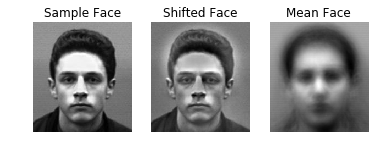

In [5]:
# get the j'th face
j = 37

rec = FacialRec()

# get the mean face
mean_face = rec.mu

# get a sample face
face = rec.F[:, j]

# get shifted face
shifted_face = rec.Fbar[:, j]

# display faces
show_multiple([face, shifted_face, mean_face], ["Sample Face", "Shifted Face", "Mean Face"])

<h1 style="color: green">5. Computing SVD and Eigenfaces</h1>

- In `FacialRec.__init__()`, we compute the compact SVD $(UΣV^{H})$ of $\bar{F}$ and store the $U$ as an attribute. Recall that U, in this case, is an orthonormal basis for the range of $\bar{F}$, and the columns of U are the are ordered from greatest to least importance of any given face.

First 3 eigenfaces: there is more of U_0 in every face than any other eigenface


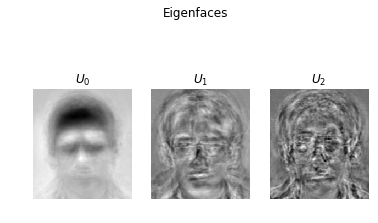

In [6]:
# show 1'st, 50th, and 100th faces in U
rec = FacialRec()
faces = rec.U[:, [1, 50, 100]]
print("First 3 eigenfaces: there is more of U_0 in every face than any other eigenface")
show_multiple([faces[:, 0], faces[:, 1], faces[:, 2]], ["$U_0$", "$U_1$", "$U_2$"], "Eigenfaces")

<h1 style="color: green">6. Approximating a Face with Eigenfaces</h1>

In the block below, we do the following:

<ol>
    <li>Select one of the shifted images $\bar{\mathbf{f}}_i$.</li>
    <li>Let $s$ be the number of eigenfaces used to reconstruct a face. For 4 values of $s$, we use <code>FacialRec.project()</code> to compute the corresponding $s$-projection $\widehat{\mathbf{f}}_i$. Then we compute the reconstruction $\widetilde{\mathbf{f}}_i$, by adding back the mean face.</li>
    <li>Display each of the reconstructions and the original image.</li>
</ol>

Note that by $s = 256$, the face is a perfect approximation.

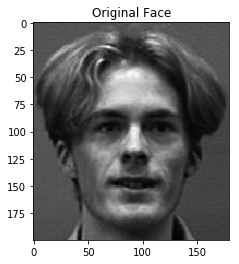

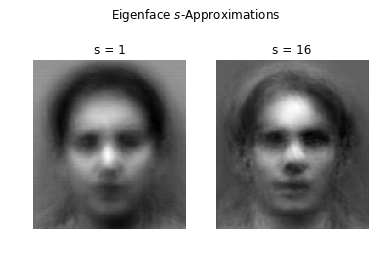

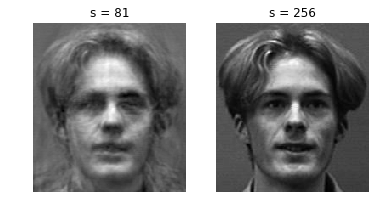

In [13]:
# get the j'th face
j = 82

rec = FacialRec()

# display j'th face
face = rec.Fbar[:, j]
show(face + rec.mu, "Original Face")

# print 4 reconstructions of varying accuracies
faces = []
names = []
for i in range(1, 5):
    names.append(f"s = {i**4}")

    # project face
    proj = rec.project(face, i**4)

    # reconstruct face
    recon = rec.U[:, :i**4] @ proj + rec.mu

    # show reconstruction
    faces.append(recon)

# display approximations
show_multiple(faces[:2], names[:2], r"Eigenface $s$-Approximations")
show_multiple(faces[2:], names[2:])

<h1 style="color: green; font-weight: 1">7. Matching a Random Face</h1>

<p>Here we draw a random face, $g$, from the data set and call <code>FacialRec.find_nearest()</code> on it. 

</br></br>By default, this method projects the entire data set of faces onto the space spanned by the first 38 colums of U. Then it returns the face from the set closest to $g$ with respect to the 2-norm.</p>

Observe that the face is almost always identital.

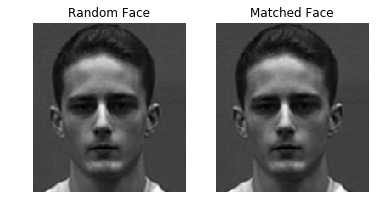

In [45]:
# get a random face from the data set
rec = FacialRec()
rand_index = np.random.randint(0, rec.F.shape[1] - 1)
rand_face = rec.F[:, rand_index]

# match the face in the data set
matched_face_index = rec.find_nearest(rand_face)
matched_face = rec.F[:, matched_face_index]

# display both side by side
show_multiple([rand_face, matched_face], ["Random Face", "Matched Face"])

And now we do it again 5 times!

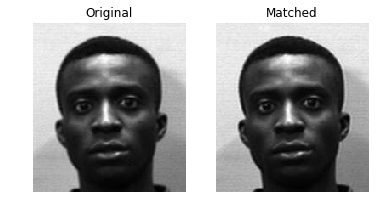

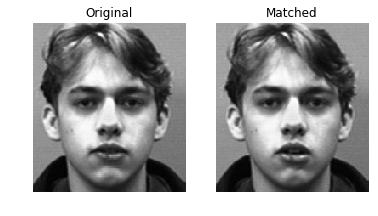

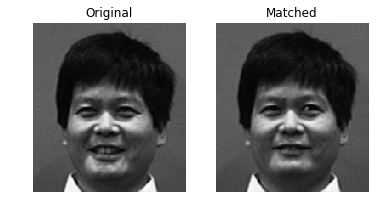

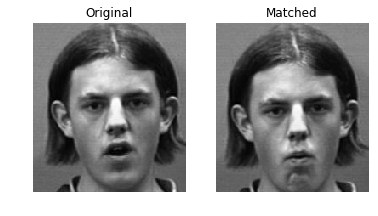

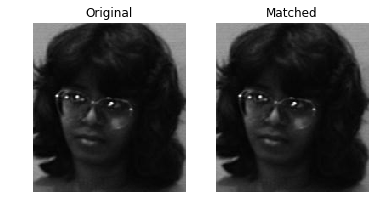

In [50]:
n = 5

# draw n faces randomly and loop through them
for i, test_image in enumerate(sample_faces(n)):
    # 'test_image' is a now flattened face vector.
    
    # match the face in the data set
    matched_face_index = rec.find_nearest(test_image)
    matched_face = rec.F[:, matched_face_index]
    
    show_multiple([test_image, matched_face], ["Original", "Matched"])
    

<h3>And that is now eigenfaces can be used to identify a random face from within a group.</h13>